In [1]:
%load_ext autoreload
%autoreload 2

# Trying custom-made stimulations with PyRhO
# What kind of undocument mess is this simulator

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import neurom as nm
from neurom import viewer
from tqdm import tqdm

import brian2 as b2
import pyrho as pr # <-------

# Using pre-made protocols

WARNING    Variable Theta is a shared variable but it will be recorded once for every target. [brian2.monitors.statemonitor]



Running 'step' protocol with Brian for the Three-state ChR2 model... 

{nRuns=1, nPhis=1, nVs=1}


WARNING    Cannot use Cython, a test compilation failed: Microsoft Visual C++ 14.0 is required. Get it with "Microsoft Visual C++ Build Tools": https://visualstudio.microsoft.com/downloads/ (DistutilsPlatformError) [brian2.codegen.runtime.cython_rt.cython_rt.failed_compile_test]
INFO       Cannot use compiled code, falling back to the numpy code generation target. Note that this will likely be slower than using compiled code. Set the code generation to numpy manually to avoid this message:
prefs.codegen.target = "numpy" [brian2.devices.device.codegen_fallback]
WARNING    <string>:27: RuntimeWarning: invalid value encountered in true_divide
 [py.warnings]
WARNING    <string>:50: RuntimeWarning: invalid value encountered in true_divide
 [py.warnings]
WARNING    <string>:56: RuntimeWarning: invalid value encountered in true_divide
 [py.warnings]


Data saved to disk: data\step3s.pkl

Finished 'step' protocol with Brian for the Three-state ChR2 model in 2.24s
--------------------------------------------------------------------------------



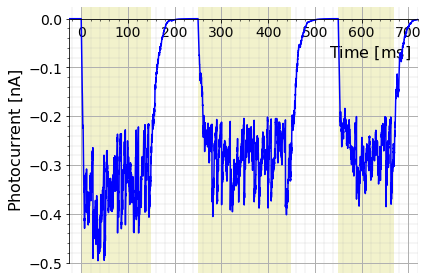

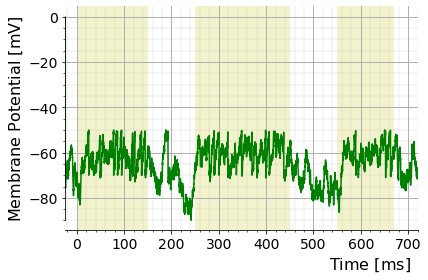

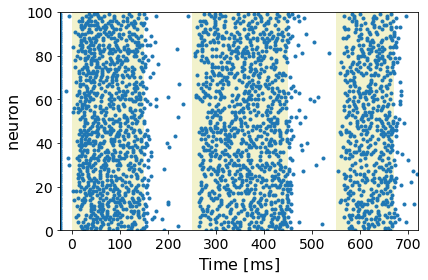

In [3]:
# Defining the ChR2 model
n_states = '3' #number of states in the channel model : 3, 4 or 6
params = pr.modelFits[n_states]['ChR2'] #only ChR2 seems to be pre-packed with pyrho

# Defining the pyrho model
rho = pr.models[n_states](params)

# Defining the equations
netParams = {'tau_m':10*b2.ms,
             'R_m':70*b2.Mohm,
             'E_m':-70*b2.mV,
             'v_t0':-50*b2.mV,
             'sigma':10*b2.mV,
             't_ref':4*b2.ms}
eq_opto = '''
dv/dt = ((-I*R_m)+E_m-v)/tau_m + sigma*xi*tau_m**-0.5 : volt
''' + rho.brian_phi_t # writes the model in a brian-interpretable string
eq_norm = '''
dv/dt = (E_m-v)/tau_m + sigma*xi*tau_m**-0.5 : volt
'''

# Defining the stimulation protocol 
protocol = pr.protocols['step']()
protocol.phis = [1e14] #photons 
protocol.Vs = [None]
protocol.cycles = [[150, 100], [200, 100], [120, 50]] #on-off times
# Defining the neuron
neuron = b2.NeuronGroup(100, eq_opto, threshold='v>v_t0', reset='v=E_m', refractory='t_ref', 
                        namespace=netParams, name='Inputs', method='euler')

# Run the simulation
net = b2.Network(b2.collect())
monitors = {'states' : b2.StateMonitor(neuron, rho.brianStateVars, record=0),   # Record states
            'I'      : b2.StateMonitor(neuron, 'I', record=0),                  # Record current
            'V'      : b2.StateMonitor(neuron, 'v', record=0),                  # Record voltage
            'states2' : b2.StateMonitor(neuron, True, record=True), 
            'spikes' : [b2.SpikeMonitor(neuron, name='neuron')]}
net.add(monitors)

sim = pr.simulators['Brian'](protocol, 
                            rho, 
                            pr.simParams['Brian'],
                            net,
                            netParams,
                            monitors)
sim.run()
sim.plot()

# Without the protocol object

In [4]:
test = ''' dC/dt = Gr*D - Ga*C                         : 1
            dO/dt = Ga*C - Gd*O                         : 1
            dD/dt = Gd*O - Gr*D                         : 1
            Ga = Theta*k_a*((phi**p)/(phi**p + phi_m**p))        : second**-1
            Gr = Gr0 + Theta*k_r*((phi**q)/(phi**q + phi_m**q))  : second**-1
            f_phi = O                                   : 1
            f_v = (1-exp(-(v-E)/v0))/((v-E)/v1)         : 1
            I = g0*f_phi*f_v*(v-E)                      : amp
            Theta = int(phi > 0*phi)              : 1 (shared)'''

WARNING    <string>:45: RuntimeWarning: invalid value encountered in true_divide
 [py.warnings]
WARNING    <string>:51: RuntimeWarning: invalid value encountered in true_divide
 [py.warnings]


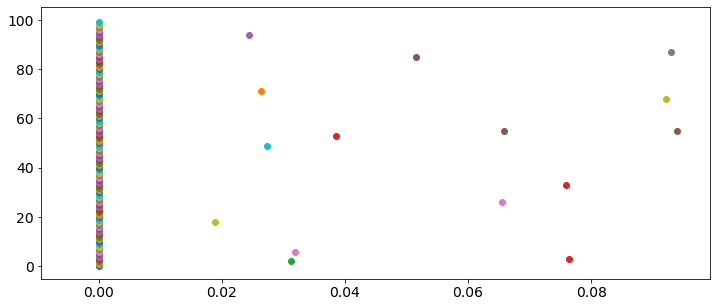

In [28]:
b2.start_scope()

# Extracting the opsin model from PyRhO
n_states = '3' #number of states in the channel model : 3, 4 or 6
pyrho_params = pr.modelFits[n_states]['ChR2'] #only ChR2 seems to be pre-packed with pyrho
rho = pr.models[n_states](pyrho_params)
opsin_dict = {}
for i, k in pyrho_params.items() :
    opsin_dict[i] = k.value * pr.modelUnits[i]



# Defining the equations
netParams = {'tau_m':10*b2.ms,
             'R_m':70*b2.Mohm,
             'E_m':-70*b2.mV,
             'v_t0':-50*b2.mV,
             'sigma':10*b2.mV,
             't_ref':4*b2.ms}
netParams.update(opsin_dict)
netParams.update({'phi' : 1 * pr.modelUnits['phi_m']})
netParams.update({'p' : 12})
netParams.update({'q' : 12})

eq_opto = '''
dv/dt = ((-I*R_m)+E_m-v)/tau_m + sigma*xi*tau_m**-0.5 : volt
'''
eq_opto += test


# Defining the neuron
neuron = b2.NeuronGroup(100, eq_opto, threshold='v>v_t0', reset='v=E_m', refractory='t_ref', 
                        namespace=netParams, name='Inputs', method='euler')

# Run the simulation
net = b2.Network(b2.collect())
mon = b2.SpikeMonitor(neuron, name='neuron')
mon2 = b2.StateMonitor(neuron, variables = True, record = True)
net.add(mon)
net.add(mon2)
 
b2.run(100 * b2.ms)

fig, ax = plt.subplots(figsize = (12,5))
for idx, times in mon.spike_trains().items() :
    ax.scatter(times,
               np.full_like(times, idx))
    

# Comparing

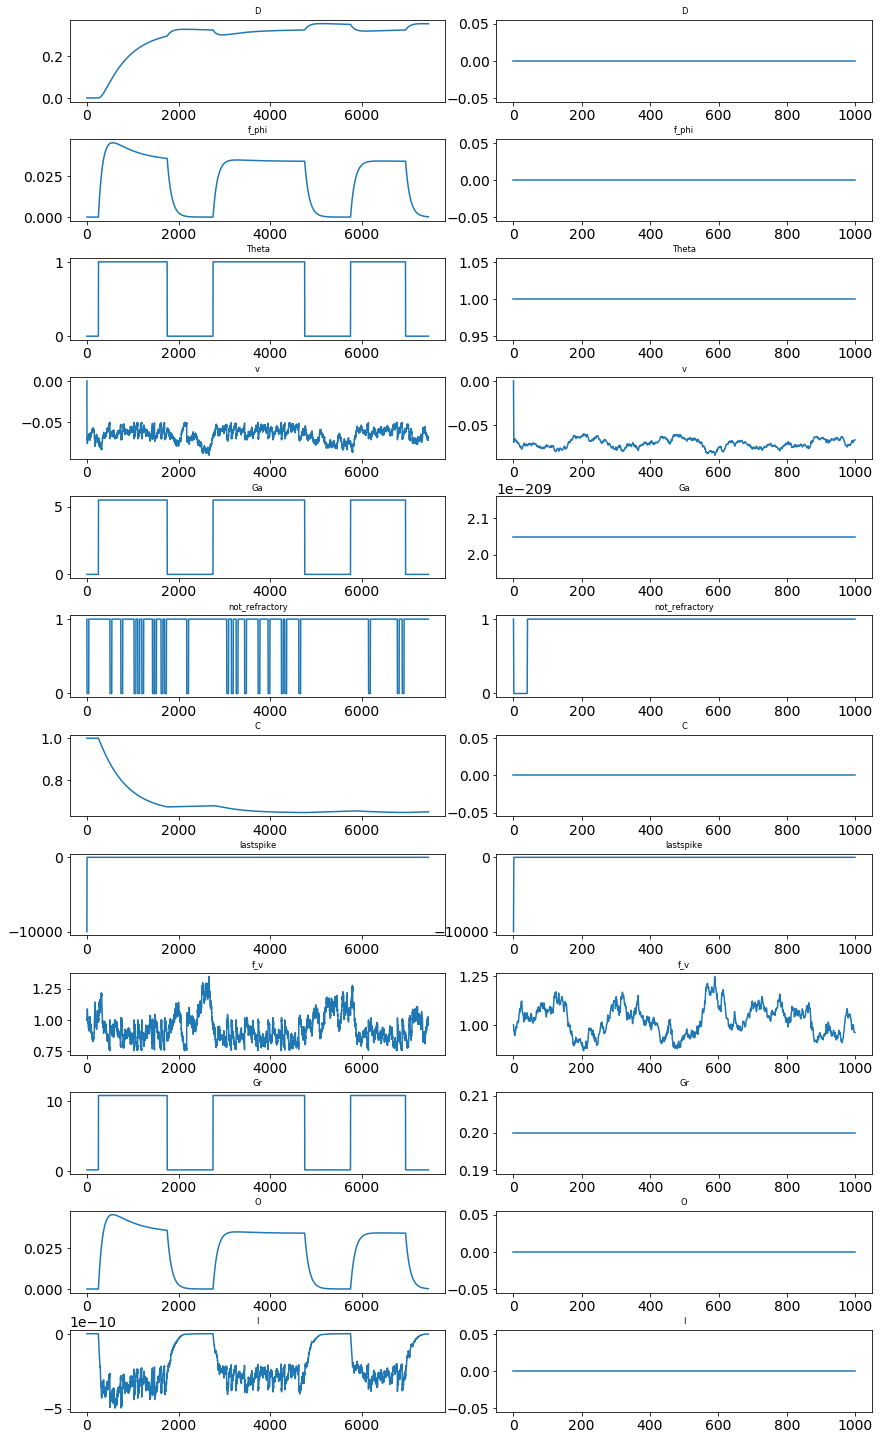

In [29]:
fig, axs = plt.subplots(nrows = 12, ncols = 2, figsize = (12,20))
fig.tight_layout()

# PyRhO sim
axs[0,0].plot(monitors['states2'].D[0,:])
axs[0,0].set_title('D')
axs[1,0].plot(monitors['states2'].f_phi[0,:])
axs[1,0].set_title('f_phi')
axs[2,0].plot(monitors['states2'].Theta[0,:])
axs[2,0].set_title('Theta')
axs[3,0].plot(monitors['states2'].v[0,:])
axs[3,0].set_title('v')
axs[4,0].plot(monitors['states2'].Ga[0,:])
axs[4,0].set_title('Ga')
axs[5,0].plot(monitors['states2'].not_refractory[0,:])
axs[5,0].set_title('not_refractory')
axs[6,0].plot(monitors['states2'].C[0,:])
axs[6,0].set_title('C')
axs[7,0].plot(monitors['states2'].lastspike[0,:])
axs[7,0].set_title('lastspike')
axs[8,0].plot(monitors['states2'].f_v[0,:])
axs[8,0].set_title('f_v')
axs[9,0].plot(monitors['states2'].Gr[0,:])
axs[9,0].set_title('Gr')
axs[10,0].plot(monitors['states2'].O[0,:])
axs[10,0].set_title('O')
axs[11,0].plot(monitors['states2'].I[0,:])
axs[11,0].set_title('I')

# Custom sim
axs[0,1].plot(mon2.D[0,:])
axs[0,1].set_title('D')
axs[1,1].plot(mon2.f_phi[0,:])
axs[1,1].set_title('f_phi')
axs[2,1].plot(mon2.Theta[0,:])
axs[2,1].set_title('Theta')
axs[3,1].plot(mon2.v[0,:])
axs[3,1].set_title('v')
axs[4,1].plot(mon2.Ga[0,:])
axs[4,1].set_title('Ga')
axs[5,1].plot(mon2.not_refractory[0,:])
axs[5,1].set_title('not_refractory')
axs[6,1].plot(mon2.C[0,:])
axs[6,1].set_title('C')
axs[7,1].plot(mon2.lastspike[0,:])
axs[7,1].set_title('lastspike')
axs[8,1].plot(mon2.f_v[0,:])
axs[8,1].set_title('f_v')
axs[9,1].plot(mon2.Gr[0,:])
axs[9,1].set_title('Gr')
axs[10,1].plot(mon2.O[0,:])
axs[10,1].set_title('O')
axs[11,1].plot(mon2.I[0,:])
axs[11,1].set_title('I')


plt.show()


# This is a convoluted nightmare, I'll just rewrite the equations

In [30]:
neweqs = ''' dC/dt = Gr*D - Ga*C                         : 1
            dO/dt = Ga*C - Gd*O                         : 1
            dD/dt = Gd*O - Gr*D                         : 1
            Ga = Theta*k_a*((phi**p)/(phi**p + phi_m**p))        : second**-1
            Gr = Gr0 + Theta*k_r*((phi**q)/(phi**q + phi_m**q))  : second**-1
            f_phi = O                                   : 1
            f_v = (1-exp(-(v-E)/v0))/((v-E)/v1)         : 1
            I = g0*f_phi*f_v*(v-E)                      : amp
            Theta = int(phi > 0*phi)              : 1 (shared)'''

In [31]:
todo : actually rewrite said equations

SyntaxError: invalid syntax (<ipython-input-31-1fa50684fc07>, line 1)